In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

%matplotlib inline

def strip(text):
#     return ' '.join(re.sub("(@[A-Za-z0-9]+)|(\&amp;)|([^0-9A-Za-z' \t])|(\w+:\/\/\S+)", " ", text.lower()).split())
    return re.sub("(@[A-Za-z0-9]+)|(\&amp;)|([^0-9A-Za-z' \t])|(\w+:\/\/\S+)", " ", text.lower())

def load_dataset(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['id', 'topic', 'label', 'tweet_text']
    df = df.loc[df.tweet_text != 'Not Available']
    df.reset_index(drop=True, inplace=True)
    df.update(pd.DataFrame({'tweet_text': [strip(tweet) for tweet in df.loc[:, 'tweet_text']]}))
    return df

In [18]:
# Load the datasets into dataframes
train_df = load_dataset('/home/kostas/Desktop/Semester 2/text engineering analytics/assignments/assignment2/twitter_datasets/train_2_labels.csv')
dev_df = load_dataset('/home/kostas/Desktop/Semester 2/text engineering analytics/assignments/assignment2/twitter_datasets/dev_2_labels.csv')
test_df = load_dataset('/home/kostas/Desktop/Semester 2/text engineering analytics/assignments/assignment2/twitter_datasets/test_2_labels.csv')
train_df.head(20)

,id,topic,label,tweet_text
0,628949369883000832,@microsoft,negative,dear the newooffice for mac is great and all...
1,628976607420645377,@microsoft,negative,how about you make a system that doesn't eat...
2,629226490152914944,@microsoft,positive,microsoft i may not prefer your gaming branch...
3,629345637155360768,@microsoft,negative,i will be downgrading and let windows10 b...
4,629650766580609026,@microsoft,positive,just ordered my 1st ever tablet surface pro...
5,629797991826722816,@microsoft,negative,after attempting a reinstall it still bricks ...
6,630159517058142208,@microsoft,positive,sunday morning quiet day so time to welcome i...
7,630542330827771904,@microsoft,negative,did break windows 10 was working fine on we...
8,630818265799921664,@microsoft,positive,innovation for jobs is just around the corner ...
9,631104156187627520,@microsoft,negative,for the 1st time has a high startup impact ...


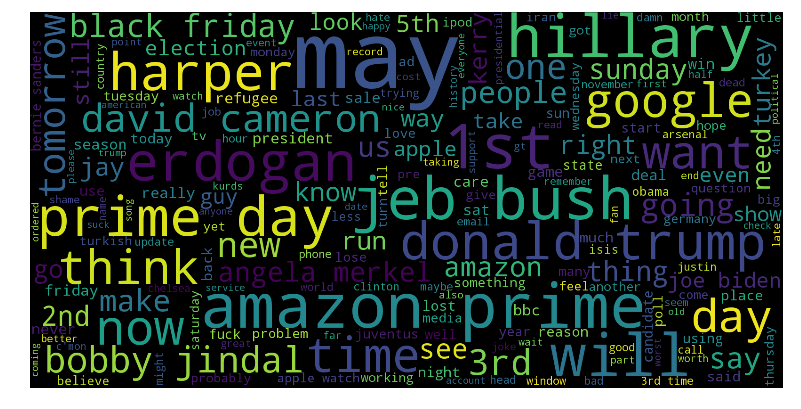

In [19]:
# Wordcloud for negative tweets
negative_tweets = train_df[train_df.label == 'negative']
negative_string = [t for t in negative_tweets.tweet_text]
negative_string = pd.Series(negative_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, random_state=1).generate(negative_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

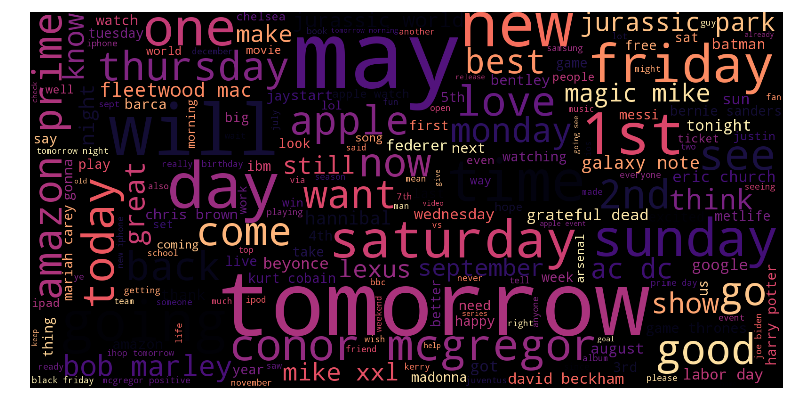

In [21]:
# Wordcloud for positive tweets
positive_tweets = train_df[train_df.label == 'positive']
positive_string = [t for t in positive_tweets.tweet_text]
positive_string = pd.Series(positive_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200, colormap='magma', random_state=1).generate(positive_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
# Term frequency per label (no limit-no threshold-no stopwords)
cvec = CountVectorizer()
cvec.fit(train_df.tweet_text)

neg_doc_matrix = cvec.transform(train_df[train_df.label == 'negative'].tweet_text)
pos_doc_matrix = cvec.transform(train_df[train_df.label == 'positive'].tweet_text)

neg_tf = neg_doc_matrix.sum(axis=0)
pos_tf = pos_doc_matrix.sum(axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos], columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,481,2291,2772
to,296,1334,1630
on,152,869,1021
and,134,792,926
in,122,790,912
of,146,694,840
for,120,664,784
is,172,609,781
it,157,609,766
you,88,585,673


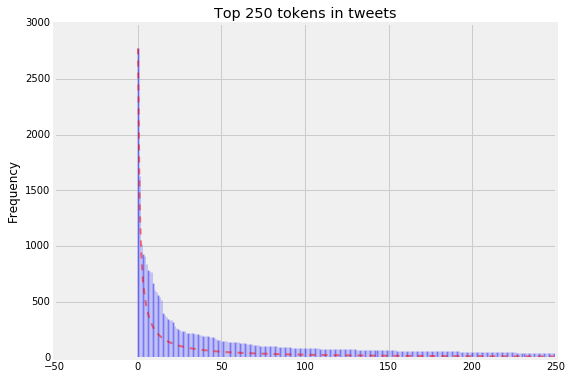

In [23]:
# Zipf's distribution
y_pos = np.arange(250)
plt.figure(figsize=(8, 6))
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1) for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:250], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 250 tokens in tweets')

In [24]:
# Term frequency per label (with limit-threshold-stop words)
cvec = CountVectorizer(stop_words='english', max_features=2500, min_df=3)
cvec.fit(train_df.tweet_text)

neg_doc_matrix = cvec.transform(train_df[train_df.label == 'negative'].tweet_text)
pos_doc_matrix = cvec.transform(train_df[train_df.label == 'positive'].tweet_text)

neg_tf = neg_doc_matrix.sum(axis=0)
pos_tf = pos_doc_matrix.sum(axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos], columns=cvec.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
tomorrow,28,513,541
day,68,274,342
just,55,282,337
going,26,199,225
friday,39,186,225
amazon,72,153,225
1st,53,161,214
time,36,173,209
apple,23,170,193
new,21,170,191


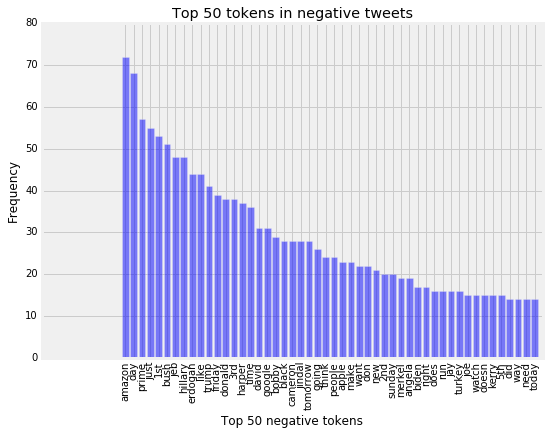

In [25]:
# Top 50 words in negative tweets
y_pos = np.arange(50)
plt.figure(figsize=(8, 6))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

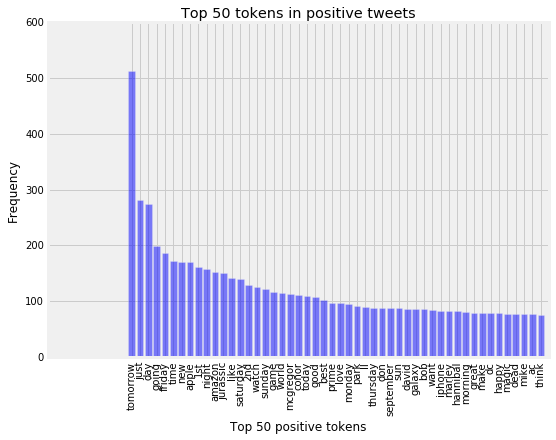

In [26]:
# Top 50 words in positive tweets
y_pos = np.arange(50)
plt.figure(figsize=(8, 6))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

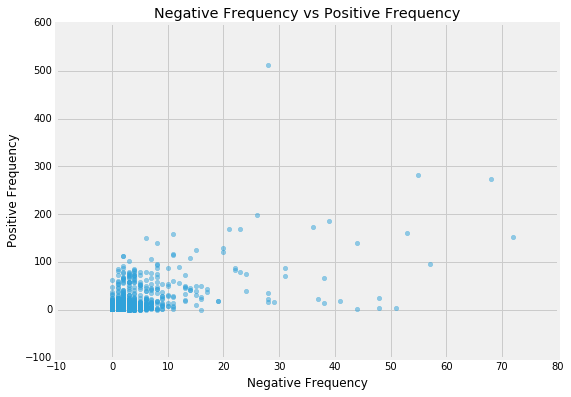

In [27]:
# Negative Frequency vs Positive Frequency per token
plt.figure(figsize=(8, 6))
ax = sns.regplot(x="negative", y="positive", fit_reg=False, scatter_kws={'alpha':0.5}, data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [28]:
# Building upon a suitable metric (1)
from scipy.stats import norm, hmean

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df['neg_rate'] = term_freq_df['negative'] / term_freq_df['total']
term_freq_df['neg_freq_pct'] = term_freq_df['negative'] / term_freq_df['negative'].sum()
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']]) if x['neg_rate']>0 and x['neg_freq_pct']>0 else 0), axis=1)
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])
term_freq_df.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
erdogan,44,2,46,0.956522,0.009450,0.018715,0.999554,1.000000,0.999777
bush,51,5,56,0.910714,0.010954,0.021647,0.999104,1.000000,0.999552
jeb,48,5,53,0.905660,0.010309,0.020386,0.999035,1.000000,0.999517
turkey,16,0,16,1.000000,0.003436,0.006849,0.999778,0.994991,0.997378
donald,38,14,52,0.730769,0.008162,0.016143,0.990320,1.000000,0.995136
trump,41,18,59,0.694915,0.008806,0.017391,0.985454,1.000000,0.992674
hillary,48,24,72,0.666667,0.010309,0.020305,0.980259,1.000000,0.990031
bobby,29,17,46,0.630435,0.006229,0.012335,0.971363,1.000000,0.985474
jindal,28,17,45,0.622222,0.006014,0.011912,0.968939,0.999999,0.984224
harper,37,23,60,0.616667,0.007947,0.015691,0.967205,1.000000,0.983329


In [29]:
# Building upon a suitable metric (2)
term_freq_df['pos_rate'] = term_freq_df['positive'] / term_freq_df['total']
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] / term_freq_df['positive'].sum()
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate']>0 and x['pos_freq_pct']>0 else 0), axis=1)
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
birthday,0,62,62,0.000000,0.000000,0.000000,0.198650,0.333261,0.248922,1.000000,0.002690,0.005365,0.801350,0.981627,0.882375
bob,1,86,87,0.011494,0.000215,0.000422,0.212912,0.403986,0.278858,0.988506,0.003731,0.007434,0.787088,0.998959,0.880457
marley,1,82,83,0.012048,0.000215,0.000422,0.213614,0.403986,0.279459,0.987952,0.003557,0.007089,0.786386,0.998212,0.879727
federer,1,73,74,0.013514,0.000215,0.000423,0.215478,0.403986,0.281050,0.986486,0.003167,0.006314,0.784522,0.994492,0.877116
mcgregor,2,113,115,0.017391,0.000430,0.000838,0.220455,0.478005,0.301746,0.982609,0.004902,0.009756,0.779545,0.999986,0.876112
conor,2,112,114,0.017544,0.000430,0.000839,0.220652,0.478005,0.301930,0.982456,0.004859,0.009670,0.779348,0.999983,0.875986
park,2,91,93,0.021505,0.000430,0.000842,0.225807,0.478005,0.306721,0.978495,0.003948,0.007864,0.774193,0.999489,0.872532
september,2,88,90,0.022222,0.000430,0.000843,0.226747,0.478005,0.307587,0.977778,0.003818,0.007606,0.773253,0.999213,0.871830
morning,2,80,82,0.024390,0.000430,0.000844,0.229604,0.478005,0.310205,0.975610,0.003471,0.006917,0.770396,0.997679,0.869429
madonna,1,61,62,0.016129,0.000215,0.000424,0.218828,0.403986,0.283884,0.983871,0.002646,0.005278,0.781172,0.979688,0.869240


In [30]:
# Plot tokens according to above metric
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', 
                                 low = min(term_freq_df.pos_normcdf_hmean), 
                                 high = max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean', 'pos_normcdf_hmean', size=5, alpha=0.3, source=term_freq_df, color={'field': 'pos_normcdf_hmean', 'transform':color_mapper})
hover = HoverTool(tooltips=[('token', '@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [31]:
# Explore sets
x_train = train_df.tweet_text
y_train = train_df.label

x_dev = dev_df.tweet_text
y_dev = dev_df.label

x_test = test_df.tweet_text
y_test = test_df.label

print('Train set:\n', len(x_train), 'entries\n', 
      '%.2f' % (len(train_df[train_df.label == 'negative'])/len(x_train)*100), '% negative\n', 
      '%.2f' % (len(train_df[train_df.label == 'positive'])/len(x_train)*100), '% positive\n')

print('Dev set:\n', len(x_dev), 'entries\n', 
      '%.2f' % (len(dev_df[dev_df.label == 'negative'])/len(x_dev)*100), '% negative\n', 
      '%.2f' % (len(dev_df[dev_df.label == 'positive'])/len(x_dev)*100), '% positive\n')

print('Test set:\n', len(x_test), 'entries\n', 
      '%.2f' % (len(test_df[test_df.label == 'negative'])/len(x_test)*100), '% negative\n', 
      '%.2f' % (len(test_df[test_df.label == 'positive'])/len(x_test)*100), '% positive\n')

Train set:
 3384 entries
 17.11 % negative
 82.89 % positive

Dev set:
 1030 entries
 26.89 % negative
 73.11 % positive

Test set:
 1105 entries
 19.46 % negative
 80.54 % positive



In [32]:
# Baseline classifier
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

tbresult = [TextBlob(i).sentiment.polarity for i in x_dev]
tbpred = ['negative' if n < 0 else 'positive' for n in tbresult]

conmat = np.array(confusion_matrix(y_dev, tbpred, labels=['positive', 'negative']))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'], columns=['predicted_positive', 'predicted_negative'])

print('Accuracy Score: {0:.2f}%'.format(accuracy_score(y_dev, tbpred) * 100))
print('-' * 80)
print('Confusion Matrix\n')
print(confusion)
print('-' * 80)
print('Classification Report\n')
print(classification_report(y_dev, tbpred))

Accuracy Score: 66.80%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                 607                 146
negative                 196                  81
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.36      0.29      0.32       277
   positive       0.76      0.81      0.78       753

avg / total       0.65      0.67      0.66      1030



In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 'negative']) / (len(x_test)) > 0.5:
        null_accuracy = len(x_test[y_test == 'negative']) / (len(x_test))
    else:
        null_accuracy = 1 - (len(x_test[y_test == 'negative']) / (len(x_test)))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(1000,10001,1000)
# n_features = np.arange(1000,20001,2500)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_dev, y_dev)
        result.append((n,nfeature_accuracy,tt_time))
    return result

print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 1000 features
null accuracy: 73.11%
accuracy score: 74.66%
model is 1.55% more accurate than null accuracy
train and test time: 0.20s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 73.11%
accuracy score: 74.85%
model is 1.75% more accurate than null accuracy
train and test time: 0.19s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 73.11%
accuracy score: 75.05%
model is 1.94% more accurate than null accuracy
train and test time: 0.21s
----------------------------------------------------------------

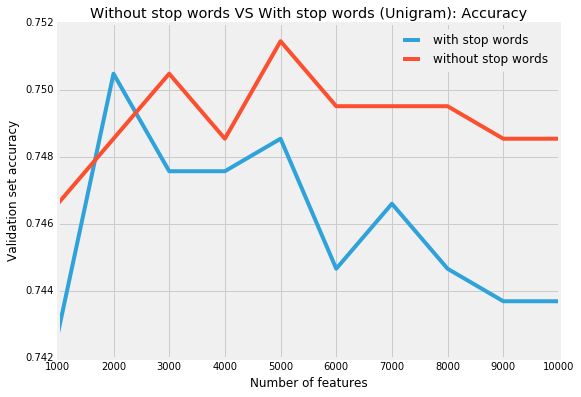

In [34]:
# Plot above results
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [35]:
# Try bigram and trigram
print("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 1000 features
null accuracy: 73.11%
accuracy score: 74.08%
model is 0.97% more accurate than null accuracy
train and test time: 0.53s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 73.11%
accuracy score: 74.66%
model is 1.55% more accurate than null accuracy
train and test time: 0.52s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 73.11%
accuracy score: 75.24%
model is 2.14% more accurate than null accuracy
train and test time: 0.55s
--------------------------------------------------------------------

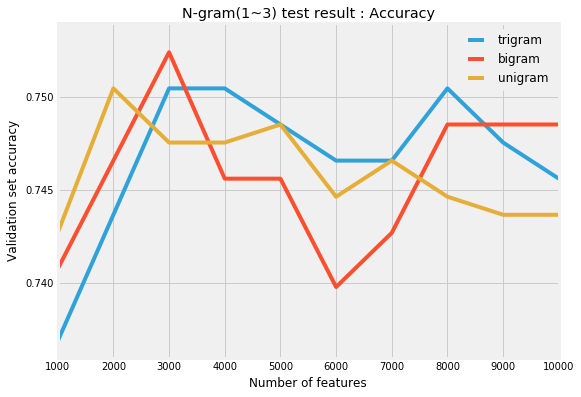

In [36]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [37]:
# Initialize structures
tweets_train = [strip(tweet) for tweet in train_df.loc[:, 'tweet_text']]
label_train = [label for label in train_df.loc[:, 'label']]
tweets_test = [strip(tweet) for tweet in test_df.loc[:, 'tweet_text']]
label_test = [label for label in test_df.loc[:, 'label']]

le = preprocessing.LabelEncoder()
le.fit(label_train)

label_train = le.transform(label_train)
label_test = le.transform(label_test)

vectorizer = TfidfVectorizer(min_df=3, max_features=2000, stop_words='english')
X_train = vectorizer.fit_transform(tweets_train)
X_test = vectorizer.transform(tweets_test)

In [39]:
classifier = LogisticRegression()
classifier.fit(X_train, label_train)

scores = cross_val_score(classifier, X_train, label_train, cv=10)
print(np.mean(scores), scores)

precisions = cross_val_score(classifier, X_train, label_train, cv=10, scoring='precision')
print('\nPrecision', np.mean(precisions), precisions)
recalls = cross_val_score(classifier, X_train, label_train, cv=10, scoring='recall')
print('\nRecalls', np.mean(recalls), recalls)
f1s = cross_val_score(classifier, X_train, label_train, cv=10, scoring='f1')
print('\nF1', np.mean(f1s), f1s)

predictions = classifier.predict(X_test)

0.810022221397 [ 0.68141593  0.81120944  0.81710914  0.80825959  0.83775811  0.84023669
  0.83727811  0.80473373  0.83136095  0.83086053]

Precision 0.833333953492 [ 0.81003584  0.82582583  0.83900929  0.82727273  0.83832335  0.84876543
  0.8440367   0.834375    0.83483483  0.83086053]

Recalls 0.962958820539 [ 0.80427046  0.97864769  0.96441281  0.97153025  0.99644128  0.98214286
  0.98571429  0.95357143  0.99285714  1.        ]

F1 0.892906410705 [ 0.80714286  0.89576547  0.89735099  0.89361702  0.91056911  0.91059603
  0.90939044  0.89        0.90701468  0.9076175 ]


In [40]:
# Draft
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(label_test, predictions)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.6         0.80913242]
recall: [ 0.02790698  0.99550562]
fscore: [ 0.05333333  0.89269521]
support: [215 890]


In [ ]:
# TODO later
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, recall, thresholds = roc_curve(label_test, predictions)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

In [ ]:
# TODO later
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(label_test, predictions)
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# TODO later
from sklearn.dummy import DummyClassifier
PCA
plots
possibly label imbalance
use information gain ass a metric